# EDA & Modeling

## First Exploratoy

Data : https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ

Columns : 

- DayOfWeek
- IATA_CODE_Reporting_Airline
- Origin
- Dest
- DepTime
- DepDelay
- ArrTime
- Cancelled
- AirTime

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_theme(style="whitegrid")
import plotly.express as px

import pickle
from datetime import datetime, timedelta

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [4]:
files = ['data/flight_status_01_2022.csv',
         'data/flight_status_02_2022.csv',
         'data/flight_status_03_2022.csv',
         'data/flight_status_04_2022.csv']

files_dict = {}
for num, file in enumerate(files):
        files_dict[num] = pd.read_csv(file)
        
df = pd.concat(list(files_dict.values()))

In [3]:
print(df.shape)
df.head(10)

(2154970, 8)


,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,ARR_TIME,AIR_TIME
0,1,YX,CMH,DCA,1217.0,-7.0,1401.0,56.0
1,1,YX,CMH,DCA,1218.0,-6.0,1405.0,53.0
2,1,YX,CMH,DCA,1223.0,-1.0,1345.0,59.0
3,1,YX,DCA,CMH,1028.0,18.0,1201.0,61.0
4,1,YX,DCA,CMH,1123.0,73.0,1250.0,58.0
5,1,YX,DCA,CMH,1002.0,-8.0,1133.0,57.0
6,1,YX,DCA,CMH,1502.0,292.0,1643.0,53.0
7,1,YX,DCA,MEM,NaN,NaN,NaN,NaN
8,1,YX,ATL,LGA,1430.0,-9.0,1643.0,102.0
9,1,YX,ATL,LGA,1432.0,-7.0,1637.0,104.0


In [4]:
print(f'Number of missing values : {df.isna().sum().sum()}')

Number of missing values : 309865


In [5]:
df.dropna(axis=0, how='any', inplace=True) # remove rows that do not have arriving time and not cancelled

In [6]:
print(f'Number of missing values : {df.isna().sum().sum()}')

Number of missing values : 0


In [7]:
df['DELAY_CATEG'] = np.where(df['DEP_DELAY'] <= 0, 'ON_TIME',
                             np.where(df['DEP_DELAY'] <= 30, 'LESS_THAN_30_MIN',
                                      np.where(df['DEP_DELAY'] <= 60, 'BETWEEN_30_AND_60_MIN',
                                               np.where(df['DEP_DELAY'] <= 120, 'BETWEEN_60_AND_120_MIN',
                                                                                    'OVER_120_OR_CANCELLED'))))
df['DEP_TIME'] = np.where(df['DEP_TIME'] <= 600, '00H-06H',
                             np.where(df['DEP_TIME'] <= 1200, '06H-12H',
                                      np.where(df['DEP_TIME'] <= 1800, '12H-18H', 
                                                                            '18H-24H')))

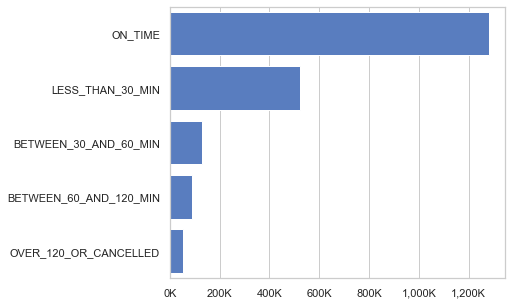

In [8]:
categ_frequency = df['DELAY_CATEG'].value_counts().reset_index(None)
categ_frequency.rename(columns={'index':'Category', 'DELAY_CATEG':'Count'}, inplace=True)

# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 5))
sns.set_color_codes("muted")
sns.barplot(x="Count", y="Category", data=categ_frequency,
            label="Total", color="b")
ax.set(ylabel="", xlabel="")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

[Text(0.5, 0, 'Count of Flights')]

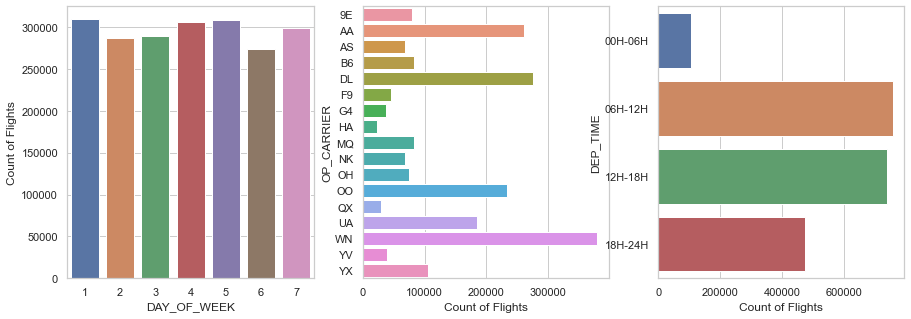

In [9]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
sns.barplot(x='DAY_OF_WEEK', 
            y='ORIGIN', 
            data=df[['DAY_OF_WEEK', 'ORIGIN']].groupby(['DAY_OF_WEEK']).count().reset_index(),
            ax=axs[0])
sns.barplot(x='ORIGIN', 
            y='OP_CARRIER', 
            data=df[['OP_CARRIER', 'ORIGIN']].groupby(['OP_CARRIER']).count().reset_index(),
            ax=axs[1])
sns.barplot(x='ORIGIN', 
            y='DEP_TIME', 
            data=df[['DEP_TIME', 'ORIGIN']].groupby(['DEP_TIME']).count().reset_index(),
            ax=axs[2])
axs[0].set(ylabel='Count of Flights')
axs[1].set(xlabel='Count of Flights')
axs[2].set(xlabel='Count of Flights')

In [10]:
df[['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEP_TIME', 'AIR_TIME', 'DELAY_CATEG']]

,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEP_TIME,AIR_TIME,DELAY_CATEG
0,1,YX,CMH,12H-18H,56.0,ON_TIME
1,1,YX,CMH,12H-18H,53.0,ON_TIME
2,1,YX,CMH,12H-18H,59.0,ON_TIME
3,1,YX,DCA,06H-12H,61.0,LESS_THAN_30_MIN
4,1,YX,DCA,06H-12H,58.0,BETWEEN_60_AND_120_MIN
...,...,...,...,...,...,...
556497,7,DL,ATL,12H-18H,123.0,ON_TIME
556498,7,DL,DFW,12H-18H,175.0,ON_TIME
556499,7,DL,DFW,12H-18H,180.0,LESS_THAN_30_MIN
556500,7,DL,DFW,12H-18H,172.0,ON_TIME


In [11]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['AIR_TIME'].describe()

count   2073502.00000
mean        114.56582
std          70.83684
min           8.00000
25%          62.00000
50%          98.00000
75%         145.00000
max         727.00000
Name: AIR_TIME, dtype: float64

## Get A Baseline - Modeling

### Preprocessing functions

In [10]:
def preprocessing(files:list):
    '''Preprocess the data, drop missing values, encode target
    
       Args:
       - files : csv path list
       
       Returns:
        A preprocessed dataframe
    '''
    
    if len(files) > 1 :
        files_dict = {}
        for num, file in enumerate(files):
                files_dict[num] = pd.read_csv(file)
                
        dataframe = pd.concat(list(files_dict.values()))
    else:
        dataframe = pd.read_csv(files[0])

    dataframe.dropna(axis=0, how='any', inplace=True) # remove rows that do not have arriving time and not cancelled

    # Create Categorical Delay Column
    dataframe['IS_DELAY'] = np.where(dataframe['DEP_DELAY'] <= 0, 0, 1)

    dataframe = dataframe[['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEP_TIME', 'AIR_TIME', 'IS_DELAY']]

    return dataframe

In [11]:
training_data = ['data/flight_status_01_2022.csv',
                 'data/flight_status_02_2022.csv',
                 'data/flight_status_03_2022.csv',
                 'data/flight_status_04_2022.csv']
validation_data = ['data/flight_status_05_2022.csv']

In [12]:
def spliting(file_for_training:list, file_for_validation:list):
    '''Split the data in training and validation arrays
    
       Args:
       - file_for_training : training csv path list
       - file_for_validation : validation csv path list
       
       Returns:
        X_train, X_val, y_train, y_val, dv
    '''
  
    df_train = preprocessing(file_for_training)
    df_val = preprocessing(file_for_validation)
    
    categorical = ['OP_CARRIER', 'ORIGIN'] 
    numerical = ['DEP_TIME', 'DAY_OF_WEEK', 'AIR_TIME']

    dv = DictVectorizer()

    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)

    val_dicts = df_val[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dicts)
    
    target = 'IS_DELAY'
    y_train = df_train[target].values
    y_val = df_val[target].values
    
    return X_train, X_val, y_train, y_val, dv

In [13]:
df_train = preprocessing(files=training_data)
df_val = preprocessing(files=validation_data)

len(df_train), len(df_val)

(2073502, 565955)

### Baseline Model

In [14]:
X_train, X_val, y_train, y_val, dv = spliting(file_for_training=training_data, 
                                              file_for_validation=validation_data)

In [41]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)

In [18]:
y_score1 = log_reg_model.predict_proba(X_val)[:,1]
y_score2 = clf_tree.predict_proba(X_val)[:,1]

In [19]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_val, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_val, y_score2)

In [ ]:
print('roc_auc_score for LogisticRegression: ', roc_auc_score(y_val, y_score1))
print('roc_auc_score for DecisionTree: ', roc_auc_score(y_val, y_score2))

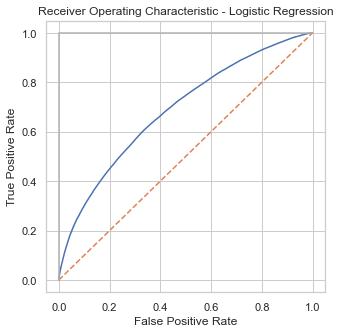

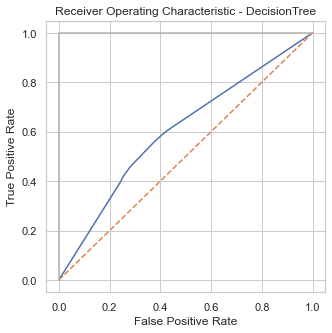

In [21]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## ML Experiments MLflow

In [149]:
import mlflow
from mlflow.tracking import MlflowClient
import boto3
import os
from dotenv import load_dotenv

load_dotenv()

MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')
MLFLOW_EXPERIMENT_NAME = os.getenv('MLFLOW_EXPERIMENT_NAME')
MLFLOW_TRACKING_USERNAME = os.getenv('MLFLOW_TRACKING_USERNAME')
MLFLOW_TRACKING_PASSWORD = os.getenv('MLFLOW_TRACKING_PASSWORD')

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
client = MlflowClient(MLFLOW_TRACKING_URI)

### Get the best algorithm

In [ ]:
for model_class in (LogisticRegression, DecisionTreeClassifier, xgb):

    with mlflow.start_run():
            
        if model_class == xgb:

            train = model_class.DMatrix(X_train, label=y_train)
            valid = model_class.DMatrix(X_val, label=y_val)
            
            mlflow.set_tag("model", "XGBClassifier")
            
            model = model_class.train(
                params={'max_depth':4, 'objective': 'binary:logistic', 'seed': 42},
                dtrain=train,
                num_boost_round=100,
                evals=[(valid, 'validation')],
                early_stopping_rounds=50
            )
            
            y_pred = model.predict(valid)
            
            precision = precision_score(y_val, y_pred.round())
            
            mlflow.log_metric("precision", precision_score(y_val, y_pred.round()))
            mlflow.log_metric("recall", recall_score(y_val, y_pred.round()))
            mlflow.log_metric("roc auc", roc_auc_score(y_val, y_pred.round()))
            
        elif model_class == LogisticRegression:
            
            mlflow.set_tag("model", type(model_class()).__name__)

            model = model_class(max_iter=1000).fit(X_train, y_train)
            y_pred = model.predict(X_val)
            
            mlflow.log_metric("precision", precision_score(y_val, y_pred))
            mlflow.log_metric("recall", recall_score(y_val, y_pred))
            mlflow.log_metric("roc auc", roc_auc_score(y_val, y_pred))
            
        else:
            
            mlflow.set_tag("model", type(model_class()).__name__)

            model = model_class(min_samples_split=10,max_depth=4).fit(X_train, y_train)
            y_pred = model.predict(X_val)
            
            mlflow.log_metric("precision", precision_score(y_val, y_pred))
            mlflow.log_metric("recall", recall_score(y_val, y_pred))
            mlflow.log_metric("roc auc", roc_auc_score(y_val, y_pred))

### Get the best model with hyperparameter tuning

In [15]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [40]:
def hyperparameter_tuning(train, valid, y_val):
    ''' Tune the model with HyperOpt and log runs in mlflow
        
        Args
          - train : xgb DMatrix of training features
          - valid : xgb DMatrix of validation features
          - y_val : array of validation target values
        
        Returns
    '''
  
    def objective(params):
        with mlflow.start_run():
            
            mlflow.set_tag("model", "XGBClassifier")
            mlflow.set_tag("run type", "hyperparameter tuning")
            
            mlflow.log_params(params)
            
            model = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=50,
                evals=[(valid, 'validation')],
                early_stopping_rounds=50
            )
            
            y_pred = model.predict(valid)
            
            precision = precision_score(y_val, y_pred.round())
            
            mlflow.log_metric("precision", precision_score(y_val, y_pred.round()))
            mlflow.log_metric("recall", recall_score(y_val, y_pred.round()))
            mlflow.log_metric("roc auc", roc_auc_score(y_val, y_pred.round()))

        return {'loss': -precision, 'status': STATUS_OK}

    search_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
        'learning_rate': hp.loguniform('learning_rate', -3, 0),
        'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
        'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
        'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
        'objective': 'binary:logistic',
        'seed': 42
    }

    best_result = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=3,
        trials=Trials()
    )
    return

In [ ]:
hyperparameter_tuning(train, valid, y_val)

### Train and register the best model 

In [111]:
def find_and_train_best_model(train, valid, y_val, dv, client):
    ''' Select the best model from the previous runs and train the model
        to keep it in the S3 bucket artifacts folder.
        
        Args
          - train : xgb DMatrix of training features
          - valid : xgb DMatrix of validation features
          - y_val : array of validation target values
          - dv : fitted DictVectorizer
          - client : MlflowClient
        
        Returns
    '''
  
    with mlflow.start_run():

        filter_query = "tags.`run type` = 'hyperparameter tuning'"
        hypertuning_runs = client.search_runs(experiment_ids=["1"], filter_string=filter_query, order_by=["metrics.precision DESC", "attributes.start_time DESC"], max_results=50)

        best_run_id = hypertuning_runs[0].info.run_id
        best_run_params = hypertuning_runs[0].data.params

        mlflow.set_tag("model", "XGBClassifier")
        mlflow.set_tag("run type", "best model")
        
        mlflow.log_params(best_run_params)
        
        model = xgb.train(
            params=best_run_params,
            dtrain=train,
            num_boost_round=50,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        
        y_pred = model.predict(valid)
        
        mlflow.log_metric("precision", precision_score(y_val, y_pred.round()))
        mlflow.log_metric("recall", recall_score(y_val, y_pred.round()))
        mlflow.log_metric("roc auc", roc_auc_score(y_val, y_pred.round()))

        with open("models/preprocessor.b", "wb") as f_out:
            pickle.dump(dv, f_out)
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlflow.xgboost.log_model(model, artifact_path="models")

In [ ]:
find_and_train_best_model(train, valid, y_val, dv, client)

In [215]:
def register_and_set_stage_model(client):
    ''' Register the model trained and set its stage
        If the model is better than the production one,
        put it in staging, if not put it in the archives.
        
        Args
        - Client : MLflow client
        
        Returns
    '''
    
    best_model_runs = client.search_runs(experiment_ids=["1"], filter_string="tags.`run type` = 'best model'", order_by=["attributes.start_time DESC"], max_results=5)
    run_id = best_model_runs[0].info.run_id # save the most recent best model run id 
    
    # Register the model
    mv = mlflow.register_model(
            model_uri=f"runs:/{run_id}/models",
            name='flight-delay-classifier'
        )
    version = mv.version

    # Get the production model's run id
    registered_model = client.search_registered_models(filter_string="name='flight-delay-classifier'")
    production_run_id = [model.run_id for model in registered_model[0].latest_versions if model.current_stage == 'Production']
    if len(production_run_id) > 0:
        # Get precision metric of both run 
        production_run = client.get_run(production_run_id[0])
        production_run_precision = production_run.data.metrics['precision']
        
        best_run = client.get_run(run_id)
        best_run_precision = best_run.data.metrics['precision']
        
        if best_run_precision > production_run_precision:
            model_version = version
            new_stage = "Production"
            client.transition_model_version_stage(
                name='flight-delay-classifier',
                version=model_version,
                stage=new_stage,
                archive_existing_versions=False
            )
            print(f'The version {version} of flight-delay-classifier model has been set to {new_stage}')
        else:
            model_version = version
            new_stage = "Archived"
            client.transition_model_version_stage(
                name='flight-delay-classifier',
                version=model_version,
                stage=new_stage,
                archive_existing_versions=False
            )
            print(f'The version {version} of flight-delay-classifier model has been set to {new_stage}')
    else:
        model_version = version
        new_stage = "Production"
        client.transition_model_version_stage(
            name='flight-delay-classifier',
            version=model_version,
            stage=new_stage,
            archive_existing_versions=False
        )
        print(f'The version {version} of flight-delay-classifier model has been set to {new_stage}')

In [ ]:
register_and_set_stage_model(client)